In [1]:
import numpy as np
import pandas as pd
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim

# Sklearn packages
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# XGBoost packages
from xgboost.sklearn import XGBRegressor
import matplotlib.pyplot as plt

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting parameters
plt.rcParams.update({
"text.usetex":True,
"font.family":"sans-serif",
"font.serif":["Computer Modern Roman"]})
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.width'] = 1

# User defined files and classes
import sys
sys.path.append('/Users/maitreyeesharma/WORKSPACE/PostDoc/Chemistry/SPIRAL/codes/RL/ReLMM/src/ReLMM')
from read_data import Inputs as inputs
import utils_dataset as utilsd
from environment import Environment
from qlearning import QNetwork
from predictors import Predictors as predictor_models

In [2]:
## Main Function

# Reading the input json file with dataset filename and path information
with open('inputs.json', "r") as f:
    input_dict = json.load(f)

run_folder = input_dict['RunFolder']
input_type = input_dict['InputType']
input_path = input_dict['InputPath']
input_file = input_dict['InputFile']
output_dir = input_dict['OutputDirectory']

# Create a new output directory if it does not exist
isExist = os.path.exists(output_dir)
if not isExist:
    os.makedirs(output_dir)
    print("The new directory is created!", output_dir)

input_data = inputs(input_type=input_type,
                           input_path=input_path,
                           input_file=input_file)

X_data, Y_data, descriptors = input_data.read_inputs()
X_stand, X_stand_df, scalerX = utilsd.standardize_data(X_data)
Y_stand, Y_stand_df, scalerY = utilsd.standardize_data(pd.DataFrame({'target':Y_data[:,0]}))
X_stand, X_test_stand_df, Y_stand, Y_test_stand_df = train_test_split(X_stand_df, Y_stand_df, test_size=0.1, random_state=0)

#---- Uncomment for synthetic dataset
# test_file = input_dict['TestFile']
# input_data2 = inputs(input_type=input_type,
#                            input_path=input_path,
#                            input_file=test_file)
# X_testdata, Y_testdata, descriptors_test = input_data2.read_inputs()
# X_test_stand = scalerX.transform(X_testdata)
# X_test_stand_df = pd.DataFrame(X_test_stand, columns=X_stand_df.columns)
# Y_test_stand_df = pd.DataFrame(scalerY.transform(pd.DataFrame({'target':Y_testdata[:,0]})), columns=Y_stand_df.columns)

# Dataset parameters
total_num_features = len(descriptors)

# Environment parameters
state_size = total_num_features  # Size of the state space
N_agents = total_num_features # Number of agents
action_size = 2  # Number of possible actions
N_steps = 100 # Number of steps to take per episode
predictor_model = predictor_models()

# Hyperparameters
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.995  # Decay rate of exploration
gamma = 0.95  # Discount factor
learning_rate = 0.001

# Initialize environment and Q-networks for each agent
env = Environment(state_size,action_size,N_agents,N_steps)
agent_model = {}
agent_optimizer = {}
agent_qvalue = {}

for i_agent in range(N_agents):
    model_name = 'agent'+str(i_agent)+'_model'
    saveModel_filename = output_dir+model_name+'.pt'
    optimizer_name = 'agent'+str(i_agent)+'_optimizer'
    agent_model[model_name] = QNetwork(env.state_size, env.action_size)
    agent_optimizer[optimizer_name] = optim.Adam(agent_model[model_name].parameters(), lr=learning_rate)
    agent_model[model_name].load_state_dict(torch.load(saveModel_filename))


Reading data for the input dataset type:  Gryffin
This class contains the predictor models to generate rewards for agents


In [3]:
# Testing the trained agents
state = env.reset()
total_rewards = np.zeros(N_agents)

while True:
    with torch.no_grad():
        actions_list = []
        for i_agent in range(N_agents):
            model_name = 'agent'+str(i_agent)+'_model'
            q_values = agent_model[model_name](torch.tensor(state, dtype=torch.float32))
            actions_list.append(torch.argmax(q_values).item())        
        actions = np.array(actions_list)

    next_state, done = env.step(actions)
    rewards, feature_importance_dict_rl, mse_rl = env.get_rewards_test(predictor_model,X_test_stand_df,Y_test_stand_df)    
    total_rewards += rewards  
    state = next_state

    if done:
        break

importance_df_rl = pd.DataFrame.from_dict(data=feature_importance_dict_rl, orient='index')
importance_df_rl.to_csv(output_dir+'rl_test.csv')
mse_test_rl = pd.DataFrame(data=[mse_rl], columns=['RL MSE'])
mse_test_rl.to_csv(output_dir+'mse_rl_test.csv')
print(f"Test Total Rewards: {total_rewards}, state: {state}")


Test Total Rewards: [1245.69533063 1245.69533063 1245.69533063 1245.69533063 1245.69533063
 1245.69533063 1245.69533063 1245.69533063 1245.69533063 1245.69533063
 1245.69533063 1245.69533063 1245.69533063 1245.69533063], state: [0 0 0 1 1 0 1 1 0 1 1 0 1 0]


In [4]:
def xgboost_parity_plot(x_stand, y_stand, selected_descriptors):
    x_train, x_test, y_train, y_test = train_test_split(x_stand, y_stand,
                                                        test_size=0.1,
                                                        random_state=40)

    clf = XGBRegressor(n_estimators=100, learning_rate=0.025, max_depth=20, verbosity=0, booster='gbtree',
        reg_alpha=np.exp(-6.788644799030888), reg_lambda=np.exp(-7.450413274554533),
        gamma=np.exp(-5.374463422208394), subsample=0.5, objective= 'reg:squarederror', n_jobs=1)

    _ = clf.get_params()
    clf.fit(x_train, y_train)   
    _ = clf.score(x_train, y_train)
    _ = cross_val_score(clf, x_train, y_train,cv=2)
    ypred_train = clf.predict(x_train)
    _ = mean_squared_error(y_train, ypred_train)
    # Generalization Error --> Used to assigning RL rewards
    ypred_test = clf.predict(x_test)
    mse_test = mean_squared_error(y_test, ypred_test)
    # Get the importance of each feature
    f_importance = clf.get_booster().get_score(importance_type='gain')
    _ = max(f_importance.values())

    return mse_test, clf


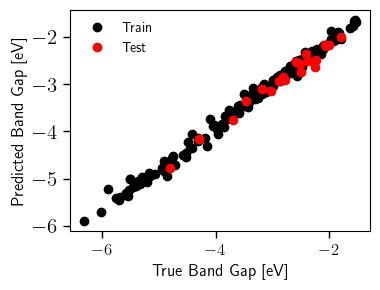

In [5]:
# Testing the trained agents
save_plot = True
state = state
descriptors = X_stand_df.columns
sampled_descriptors = [i for i, x in enumerate(state) if x == 1]
x_stand_train = pd.DataFrame(X_stand, columns=descriptors[sampled_descriptors])
y_stand_train = Y_stand
x_stand_test = pd.DataFrame(X_test_stand_df, columns=descriptors[sampled_descriptors])
y_stand_test = Y_test_stand_df

mse_test, xgboost_model = xgboost_parity_plot(x_stand_train,y_stand_train,sampled_descriptors)
ypred_train = xgboost_model.predict(x_stand_train)
ypred_test = xgboost_model.predict(x_stand_test)

ypred_train_invtransform = scalerY.inverse_transform(ypred_train.reshape(1, -1), copy=None)
ypred_test_invtransform = scalerY.inverse_transform(ypred_test.reshape(1, -1), copy=None)

ytrue_train_invtransform = scalerY.inverse_transform(Y_stand.to_numpy().reshape(1, -1), copy=None)
ytrue_test_invtransform = scalerY.inverse_transform(Y_test_stand_df.to_numpy().reshape(1, -1), copy=None)

parity_df = pd.DataFrame({'Y_true_train':ytrue_train_invtransform.reshape(172),
                          'Y_pred_train':ypred_train_invtransform.reshape(172)})
parity_df_test = pd.DataFrame({'Y_true_test':ytrue_test_invtransform.reshape(20),
                          'Y_pred_test':ypred_test_invtransform.reshape(20)})

parity_df.to_csv(output_dir+'/parity_plot_train.csv',index=False)

parity_df_test.to_csv(output_dir+'/parity_plot_test.csv',index=False)

fig = plt.figure(figsize=(3.9, 3))
ax = fig.add_subplot(111)
ax.plot(ytrue_train_invtransform.reshape(172), ypred_train_invtransform.reshape(172),'ok', label='Train')
ax.plot(ytrue_test_invtransform.reshape(20), ypred_test_invtransform.reshape(20),'or', label='Test')
ax.set_xlabel('True Band Gap [eV]')
ax.set_ylabel('Predicted Band Gap [eV]')
plt.legend(frameon=False)
plt.tight_layout()
if save_plot:
    plt.savefig(output_dir+'/prediction_parity_plot.pdf', 
    bbox_inches='tight', dpi=300)
      